# Modulation Classification using Spiking Neural Network with Bindsnet 

In [1]:
import torch 
import matplotlib.pyplot as plt 
import pickle
import h5py
#%matplotlib inline
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_weights
from bindsnet.learning import PostPre
from bindsnet.analysis.visualization import summary, plot_spike_trains_for_example, plot_voltage
from bindsnet import encoding
from tqdm import tqdm



In [4]:
#define the helper's function
#define the helper's function

def loss_output(y,a_out):
    '''
    calculate the objective/Loss function
    at the last layer
    output : Loss tensor
    :param y (tensor): target label : 
    :param a_out (tensor): spike activity at the output layer
    '''
    o_de = 1 if (torch.max(torch.sum(a_out,dim=0))==0) else torch.max(torch.sum(a_out,dim=0))
    #o = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))    
    o = torch.sum(a_out,dim=0) / o_de   
    Loss = 0.5 * torch.pow(torch.norm(o - y),2)
    return Loss

def error_backprop_out(net,y,a_out):
    '''
    calculate the error at the output layer
    output : error tensor for each neuron in the layer
    input : net, network object
    input : y , target label
    input : a_out, spike activity at the output layer
    '''
    vth = net.layers["C"].thresh
    o_de = 1 if (torch.max(torch.sum(a_out,dim=0))==0) else torch.max(torch.sum(a_out,dim=0))
    #o_vec = torch.sum(a_out,dim=0) / torch.max(torch.sum(a_out,dim=0))
    o_vec = torch.sum(a_out,dim=0) / o_de
    #denom = 1 if (np.sqrt(torch.count_nonzero(o_vec - y)) == 0) else np.sqrt(torch.count_nonzero(o_vec - y))
    denom = np.sqrt(torch.count_nonzero(o_vec - y))
    #delta_Loss = (o_vec - y) / (denom +1)
    delta_Loss = (o_vec - y) / vth
    return delta_Loss


def error_backprop(net,a_hidden,a_out,deltai_nxt):
    '''
    calculate the backprop error for each layer except output layer
    output : the error backprop tensor with dimension 1 x Number of neurons in that layer
    :param : net, network object
    :input : input data
    :a_hidden : spike activity output at the hidden layer
    :a_out : spike activit output at the output/last layer
    :deltai_nxt : backprop error from the next layer
    '''
    #w = list(net.parameters())
    wij = net.connections['B','C'].w          #get the weight of the hidden layer
    Vth = net.layers["B"].thresh
    M = net.layers["B"].n#total synapses in the next layer
    m = torch.sum(a_out,dim=0).nonzero()#vector of active synapses in the next layer  
    n = torch.sum(a_hidden,dim=0).nonzero() #vector of active neuron in the next layer
    #n = 1 if (torch.sum(a_hidden,dim=0).nonzero()==0) else torch.sum(a_hidden,dim=0).nonzero()
    g_i   = 1 / Vth
    #g_bar = np.sqrt((1/(1+len(n))) * torch.sum(torch.pow(g_i[n],2)))
    g_bar = 1 if (len(n)==0) else np.sqrt((1/(len(n))) * torch.sum(torch.pow(g_i[n],2)))
    deltai = (g_i / g_bar) * np.sqrt(M/(1+len(m))) * (wij @ deltai_nxt)
    #print(torch.pow(g_i[n],2))
    return deltai
    #return g_bar

def aux_spike_activity(spike, ref_spike,tmp = 100,T=350,isPlot = True):
    '''
    calculate the continous real value spike activity based on the equation 4
    from paper Lee.et.al (2016)
    output : tensor/vector of accumulated effects of spike at the final observation time T
    input  : spike, spike activity representd in 1 or 0
    input  : ref_spike, the reference function to save computational time
    input  : tmp, time constant of decaying spike signal
    input  : T, observation time
    '''
    dt = torch.linspace(0,T-1,T) #the time axis
    xk   = torch.zeros(spike.shape) #variable to store continous real value of accummulated. spike signal    
    
    """ if (ref_spike == None):
        y = torch.exp(-dt/tmp)
    else:
        y = ref_spike    """
    y = ref_spike
    sidx = (spike).nonzero().numpy() #get the index of the spike

    # plot the binary spike activity
    if isPlot:        
        spikes = {"A":spike}
        plt.figure()
        plot_spikes(spikes)

    # calculate the accumulated spike activity    
    for id,val in enumerate(sidx):
        if val[0]==0:
            xk[:,val[1]] = np.add(xk[:,val[1]],y)
        else:
            xk[:,val[1]] = np.add(xk[:,val[1]],[*np.zeros(val[0]),*y[0:-val[0]]])

    # plot the spike signal
    if isPlot:      
        plt.figure(figsize=[10,5])
        plt.plot(dt,xk)
        plt.title("Accumulated spike activity")
        plt.xlabel("Time Steps")
        #put some legend :)
        list_legend = []
        for i in range(spike.size(1)):
            list_legend.append('neuron %s'%i)
        plt.legend((list_legend),loc='best')
        plt.show()
    # return the last value of accum spike activity    
    return xk[-1,:]

def initialize_optim_param(network):
    '''
    initialize all the optimization parameters (1st and 2nd moment for adam ) to zeros
    input : network, network object and its parameters

    '''

    V = {
        "w_out":torch.zeros(network.connections['B','C'].w.shape), 
        "w_hid":torch.zeros(network.connections['A','B'].w.shape),
        "th_out":torch.zeros(network.layers['C'].thresh.shape),
        "th_hid":torch.zeros(network.layers['B'].thresh.shape)
    }
    S = {
        "w_out" :torch.zeros(network.connections['B','C'].w.shape), 
        "w_hid" :torch.zeros(network.connections['A','B'].w.shape),
        "th_out":torch.zeros(network.layers['C'].thresh.shape),
        "th_hid":torch.zeros(network.layers['B'].thresh.shape)
    }

    return V,S

def cal_optim_param(V,S,t,grad,eta,optim,beta1=0.9,beta2=0.999):
    '''
    calculate the optimization parameters to update the weights and threshold
    output : V,S,out_grad tupple of tensor 1st moment, 2nd moment and calculated gradient    
    input  : grad, gradient of the parameters
    input  : V, first moment of gradient
    input  : S, second moment of squared gradient
    input  : t, time to be used as counter in adam
    input  : eta, learning rate
    input  : optim, various optimization technique
    
    '''
    out_grad = torch.zeros(grad.shape)
    epsilon = 1e-8
    V = (beta1*V) + ((1-beta1) * grad)              #calculate 1st moment
    S = (beta1*S) + ((1-beta2) * (grad**2)) #calculate 2nd moment
    V_t = V / (1-beta1**t) #corrected 1st moment
    S_t = S / (1-beta2**t) #corrected 2nd moment
    if (optim == 'GD'): #standard gradient descent
        out_grad = -1*eta * grad
    elif (optim == 'Momentum'):#using only momentum
        out_grad = -1*eta*V                                 #using only momentum
    elif (optim == 'RMSP'):#RMS Prop
        out_grad = -1*(eta*grad)/(np.sqrt(S_t) + epsilon)
    elif (optim=='ADAM'):
        out_grad = -1*(eta *V_t) / (np.sqrt(S_t) + epsilon)  #new calculated gradient using Adam

    #print(out_grad)
    #return the value V, S and calulated gradient
    return V, S, out_grad # update for Adam algorithm
    
def delta_weight(etaw,N,m,deltai,xj):
    '''
    calculate the delta weights in each layer
    output : the vector of weight of each layer
    input : etaw, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : deltai, vector of error backprop
    input : xj,vector of effective input spike activity
    '''
    di = torch.reshape(deltai,[1,len(deltai)])    
    #x_j = torch.sum(xj,dim=0)
    x_j = xj.reshape([len(xj),1])
    return -etaw * np.sqrt(N/(1+m)) * di * x_j
    #return  np.sqrt(N/(1+m)) * di * x_j #update with for Adam algorithm

def delta_thrs(etath,N,m,M,deltai,ai):
    '''
    calculate the delta threshold in each neuron in layer
    output : the vector of voltage threshold of each layer
    input : etath, learning rate
    input : N, total neuron in layer
    input : m, total of active synapses in layer
    input : M, total synapses in the layer
    input : deltai, vector of error backprop
    input : ai,vector of effective output spike activity
    '''
    #di  = torch.reshape(deltai,[1,len(deltai)])
    #a_i = torch.sum(ai,dim=0)
    #a_i = a_i.reshape([len(a_i),1])
    return -etath * np.sqrt(N/((1+m)*M)) * deltai * ai
    
    #return  np.sqrt(N/((1+m)*M)) * deltai * ai #update for Adam algorithm



def update_params(net,etaw,etath,di_out,di_hid,a_out,a_hid,x_out,x_hid,ref_spike,tmp,T,V,S,optim,t):
    '''torch.max(torch.sum(a_out,dim=0))
    calculate the delta weights and thresholds and update its value
    :input : net, network object and all its parameters
    input :etaw,etath , learning rate for weights and voltage threshold

    :
    '''
    N_out   = net.layers["C"].n#total neuron in the output layer
    N_hid   = net.layers["B"].n#total neuron in the hidden layer
    M_out   = N_hid #total synapses in the output layer
    M_hid   = net.layers["A"].n#total synapses in the hidden layer

    m_out   = len(torch.sum(a_out,dim=0).nonzero())#total active synapses in the output layer
    m_hid   = len(torch.sum(a_hid,dim=0).nonzero())#total active synapses in the hidden layer

    #w   = list(net.parameters())
    w   = {'out':net.connections['B','C'].w,'hid':net.connections['A','B'].w}
    vth = [net.layers["B"].thresh,net.layers["C"].thresh]
    #calculate the auxillary spike activity
    
    x_hid_aux = x_hid#aux_spike_activity(x_hid, ref_spike,tmp = tmp,T=T,isPlot = False)
    a_hid_aux = aux_spike_activity(a_hid, ref_spike,tmp = tmp,T=T,isPlot = False) 
    x_out_aux = a_hid_aux
    a_out_aux = aux_spike_activity(a_out, ref_spike,tmp = tmp,T=T,isPlot = False)

    #1. weight in the last layer
    dwout = delta_weight(etaw,N_out,m_out,di_out,x_out_aux)     
    #update with adam algorithm
    #V['w_out'],S['w_out'], dwout = cal_optim_param(V['w_out'],S['w_out'],t,dwout,etaw,optim) 
    w['out'].add_(dwout) #update the parameters
    #2. weight in the middle layer
    dwhid = delta_weight(etaw,N_hid,m_hid,di_hid,x_hid_aux)
    #V['w_hid'],S['w_hid'], dwhid = cal_optim_param(V['w_hid'],S['w_hid'],t,dwhid,etaw,optim) 
    w['hid'].add_(dwhid) #update the parameters
    #print("last layer delta w ",dwout)
    
    #3. threshold in the last layer
    d_thout = delta_thrs(etath,N_out,m_out,M_out,di_out,a_out_aux)
    #V['th_out'],S['th_out'], d_thout = cal_optim_param(V['th_out'],S['th_out'],t,d_thout,etath,optim) 
    vth[1].add_(d_thout)
    #4. threshold in the middle layer
    d_thid = delta_thrs(etath,N_hid,m_hid,M_hid,di_hid,a_hid_aux)
    #V['th_hid'],S['th_hid'], d_thid = cal_optim_param(V['th_hid'],S['th_hid'],t,d_thid,etath,optim) 
    vth[0].add_(d_thid)


    #return V and S to calculate estimation for ADAM 
    """ V = {
        "w_out" : V['w_out'],
        "w_hid" : V['w_hid'],
        "th_out": V['th_out'],
        "th_hid": V['th_hid']
    }
    S = {
        "w_out" : S['w_out'],
        "w_hid" : S['w_hid'],
        "th_out": S['th_out'],
        "th_hid": S['th_hid']
    } """
    return V,S




def build_network(network,nodes,alpha,time,T_ref,tmp,v_rest,v_thresh,prt_sum=True):
    '''
    Procedure to build the SNNs with its specified number of nodes and layer and other parameters
    

    '''

    #initialize the voltage threshold
    vth = [alpha[0]*np.sqrt(3.0/nodes[0]), alpha[1]*np.sqrt(3.0/nodes[1])]
    thres1 = (v_rest+ vth[0]) + torch.zeros(1,nodes[1])
    thres2 = (v_rest+vth[1]) + torch.zeros(1,nodes[2])

    #define the type of neuron used in each layer
    source_layer = Input(n=nodes[0],traces=True)
    hidden_layer = LIFNodes(n=nodes[1],trace=True,refrac=T_ref,thresh=thres1.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[0])
    target_layer = LIFNodes(n=nodes[2],traces=True,refrac=T_ref,thresh=thres2.squeeze(),tc_decay=t_mp,lbound=v_rest - vth[1])
    #adding layer to the network
    network.add_layer(
        layer = source_layer, name="A"
    )
    network.add_layer(
        layer = hidden_layer, name="B"
    )
    network.add_layer(
        layer = target_layer, name="C"
    )

    whid = torch.zeros(source_layer.n,hidden_layer.n)
    if (nodes[0]==1):
        whid = 0.7 - 1*torch.rand(source_layer.n,hidden_layer.n)
    else:
        whid = (np.sqrt(3.0/source_layer.n)) - 2*np.sqrt(3.0/source_layer.n)*torch.rand(source_layer.n, hidden_layer.n),

    #create a connection between input and hidden layers
    forward_connection1 = Connection(
        source = source_layer,
        target= hidden_layer,
        #weight initialization according to Lee et.al 
        #w = (np.sqrt(3.0/source_layer.n)) - 2*np.sqrt(3.0/source_layer.n)*torch.rand(source_layer.n, hidden_layer.n),
        w = whid
    )
    network.add_connection(
        connection=forward_connection1, source="A", target="B"
    )
    #create a connection between hidden layer and output layer
    forward_connection2 = Connection(
        source = hidden_layer,
        target = target_layer,
        #weight initialization according to Lee et.al    
        w = (np.sqrt(3.0/hidden_layer.n)) - 2*np.sqrt(3.0/hidden_layer.n)*torch.rand(hidden_layer.n, target_layer.n),    
    )
    network.add_connection(
        connection=forward_connection2, source="B", target="C"
    )
    #create a recurrent connection in output layer
    # Winner take all circuit
    """ recurrent_connection = Connection(
        source = target_layer,
        target= target_layer,
        w = 0.001 * (torch.eye(target_layer.n)-1),
        #w = 0.4 * (torch.eye(target_layer.n)-1),
    )

    network.add_connection(
        connection=recurrent_connection, source="C", target="C"
    ) """

    #create and add input and output layer monitor
    source_monitor = Monitor(
        obj = source_layer,
        state_vars = ("s",), #record spikes and voltages
        time = time , 
    )
    hidden_monitor = Monitor(
        obj = hidden_layer,
        state_vars=("s","v"),
        time = time ,
    )
    target_monitor = Monitor(
        obj = target_layer,
        state_vars= ("s", "v"),
        time = time ,
    )
    #add the monitor to the network
    network.add_monitor(monitor=source_monitor, name="A")
    network.add_monitor(monitor=hidden_monitor, name="B")
    network.add_monitor(monitor=target_monitor, name="C")

    if prt_sum:
        #print th network summary
        print(summary(network))

        #investigate the weight in forward and recurrent connection
        w1 = forward_connection1.w
        w2 = forward_connection2.w
        #k1 = recurrent_connection.w 
        vth1 = network.layers["B"].thresh
        vth2 = network.layers["C"].thresh
        print("max and min of 1st forward connection weights"+str(torch.max(w1))+" "+str(torch.min(w1)))
        print("max and min of 2nd forward connection weights"+str(torch.max(w2))+" "+str(torch.min(w2)))
        #print("max and min of recurrent weights "+str(torch.max(k1))+" "+str(torch.min(k1)))

        #print the voltage threshold 
        print("Voltage Threshold at hidden layer ",network.layers['B'].thresh)
        print("Voltage Threshold at output layer ",network.layers['C'].thresh)
        #check wheter or not the weigths satisfy the equation 11
        print(torch.sum(torch.pow((forward_connection2.w),2),dim=0))
        print(torch.sum(torch.pow((forward_connection1.w),2),dim=0))
        #plot the weights
        plt.figure()
        plot_weights(forward_connection1.w,wmin=-1,figsize=[6,6])
        plt.figure()
        plot_weights(forward_connection2.w,wmin=-1,figsize=[6,6])
        plt.show()


def generate_input(spike_rate,nodes,time,batch,prt_input=True):
    '''
    generate dummy random spike dataset to feed to the network
    output : input_data, random input data with dimension input_neuron * time_step
    output : y, target label in one hot encoding
    output : vary , target label in 
    input : spike_rate , max spike rate in Hz
    input : time, time for each training sample
    input : batch, the number of training sample in a batch
    '''
    input_data = torch.zeros(time * batch , nodes[0])
    for j in range(batch):
        input_rates = spike_rate * torch.rand(nodes[0])
        input_data[j*time:(j*time)+time,:]= encoding.poisson(datum=input_rates, time=time)  

    inputs = {"A":input_data}

    vary = torch.randint(low=0,high=nodes[2],size=[batch])
    if torch.max(vary) < 3:
        vary = vary + 1
    if batch == 1:
        y = torch.tensor([0, 1, 0, 0],dtype=torch.uint8) #target label
    else:
        y = torch.nn.functional.one_hot(vary)

    if prt_input:
        print("Target labels ",y)
        #plot the input train spike
        plt.ioff()
        plt.figure()
        plot_spikes(inputs)
        plt.show()
    return input_data, y, vary 

def train_snn(network,nodes,input_data,input_spike_aux,batch,optim,lr=0.002,epochs=50):
    '''
    train the spiking neural network using backpropagation 
    input : network, network object
    input : input_data, input data encoded as spike rate
    input : lr, learning rate
    input : epoch, number of epochs
    '''
    #loop for epochs
    eta_w  = lr        #learning rate for synaptic weight
    eta_th = 1 * eta_w  #learning rate for voltage threshold
    #epochs = 100
    L = torch.zeros(epochs) #store in the vector
    l = torch.zeros(batch)
    plot_train = False
    y_pred = torch.zeros(batch,nodes[2])
    #initialize the optimization parameters (ADAM, SGD, RMSprop, Momentum)
    V,S = initialize_optim_param(network)
    t   = 0 #counter required for Adam update
    for i in range(epochs): #loop for each epoch         
        for j in tqdm(range(batch)): #loop for each training sample in a batch
            #1. run forward propagation 
            inputs = {"A":input_data[j*time:(j*time)+time,:]}
            network.run(inputs=inputs,time=time)
            #1.1 obtain the spike activity in each nodes of every layer
            #x -> 
            spikes = {       
            "A" : network.monitors["A"].get("s"),
            "B" : network.monitors["B"].get("s"),
            "C" : network.monitors["C"].get("s")
            }

            a_hidden = spikes["B"].squeeze().float() #get the spike activity at the hidden layer
            a_out    = spikes["C"].squeeze().float() #get the spike activity at the output layer           

            #save the spike activity value
            y_pred[j,:] = torch.sum(a_out,dim=0)

            #print(torch.sum(a_out,dim=0)) #print the spike's output activity
            #print(torch.sum(a_hidden,dim=0)) #print the spike's hidden activity

            #x_hidden = inputs["A"].squeeze()#input_data
            x_hidden = input_spike_aux[:,j]
            x_out    = a_hidden

            #2. calculate and keep track the loss
            if (batch==1): #if the only one training sample used
                l[j] = loss_output(y,a_out)       #y[j,:] 

                delta_i_out    =  error_backprop_out(network,y,a_out)#y[j,:]
            else: #multiple training sample in  a batch
                l[j] = loss_output(y[j,:],a_out)       

                delta_i_out    =  error_backprop_out(network,y[j,:],a_out)

            #3.propagate the error backprop        
            delta_i_hid    =  error_backprop(network,a_hidden,a_out,delta_i_out)    

            #4.update the paramaters (weight & threshold)
            t = t + 1
            V,S = update_params(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden,ref_spike,t_mp,time,V,S,optim,t)       
            #update_params(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden,ref_spike,t_mp,time,V,S)

            #5.reset the membrane potential in the network
            network.layers["C"].reset_state_variables()
            network.layers["B"].reset_state_variables()      

        L[i] = torch.sum(l) / batch
        #print("vector l",l)
        print(" epochs , loss : ",i,L[i])
        if L[i] < 0.025: #if the loss is less than specified value
                break #stop the loop
        
    return L

def run_prediction(network,input_data,target_label):
    '''
    run the forward propagation of the SNNs, 
    calculate the accuracy of the network
    input : network, SNNs object
    input : input_data, spike input 
    input : target_label, the labels
    '''
    #run the final prediction
    #y  = target_label 
    y_pred_run = torch.zeros(batch,nodes[2])
    for j in range(batch):
        inputs = {"A":input_data[j*time:(j*time)+time,:]}
        network.run(inputs=inputs,time=time)
        a_out    = network.monitors["C"].get("s").squeeze().float()
        y_pred_run[j] = torch.sum(a_out,dim=0)
        #reset state variables 
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()

    print("Output spike final prediction (one hot)",y_pred_run)    
    #print("target label (one hot)",y)    

    print("output vector %s"%(torch.argmax(y_pred_run,dim=1)))
    print("target vector %s"%target_label)
    #calculate accuracy
    acc = sum(torch.argmax(y_pred_run,dim=1)==target_label)*100/batch
    print("Accuracy %s "%acc.item())

    return acc 


         NETWORK SUMMARY
         batch size:1
    ··········································
    Layer: 'A' (trainable)
   1 neurons [1]
       ·connected to 'B' by 40 synapses
    ··········································
    Layer: 'B' (trainable)
   40 neurons [40]
       ·connected to 'C' by 160 synapses
    ··········································
    Layer: 'C' (trainable)
   4 neurons [4]
Total neurons: 45 (45 trainable)
Total synapses weights: 200 (200 trainable)
max and min of 1st forward connection weightstensor(0.6995) tensor(-0.2998)
max and min of 2nd forward connection weightstensor(0.2725) tensor(-0.2717)
Voltage Threshold at hidden layer  tensor([-59.8038, -59.8038, -59.8038, -59.8038, -59.8038, -59.8038, -59.8038,
        -59.8038, -59.8038, -59.8038, -59.8038, -59.8038, -59.8038, -59.8038,
        -59.8038, -59.8038, -59.8038, -59.8038, -59.8038, -59.8038, -59.8038,
        -59.8038, -59.8038, -59.8038, -59.8038, -59.8038, -59.8038, -59.8038,
        -59.8038, -59

<Figure size 432x288 with 0 Axes>

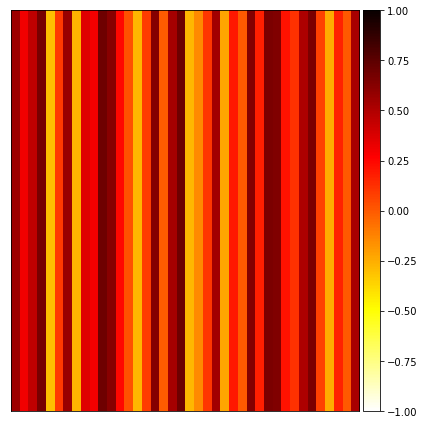

<Figure size 432x288 with 0 Axes>

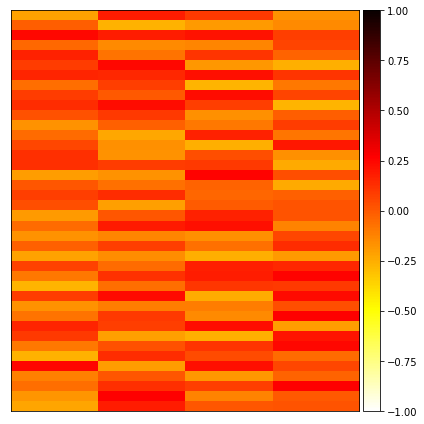

In [5]:
#define the SNN parameters
time = 100    #simulation time for each training sample
alpha = [3,2] #
T_ref = 1
t_mp = 100
v_rest = -65
v_thresh = -52

nodes = [1, 40, 4]

network = Network()

build_network(network=network,nodes=nodes,alpha=alpha,time=time,T_ref=T_ref,tmp=t_mp,v_rest=v_rest,v_thresh=v_thresh,prt_sum=True)

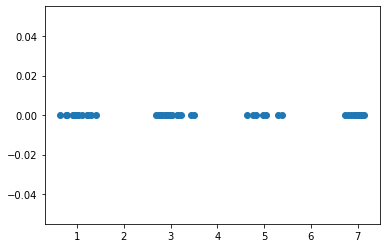

In [6]:
#generate the data 4 level of amplitude modulation
M = 4
N_samples = 50

s = np.random.randint(M, size= N_samples) #generate N random symbols

c = s * 2 + 1 #assign symbol to a certain amplitude level
n = np.random.normal(0,0.25,N_samples) #random gaussian noise
z = c + n #signal plus noise

#plot
y_ax = np.zeros(N_samples)
plt.scatter(z,y_ax)

In [10]:
print(z)

[2.80096105 5.38474967 0.77043119 0.92999265 6.73384374 1.30347745
 4.97032597 2.92544128 6.95929358 3.50048749 6.91426172 1.10553364
 6.78500459 7.08388823 6.85186212 5.3020623  1.00023799 0.96300173
 2.74750969 5.03881547 7.02479186 1.01087695 7.01572749 2.88460569
 1.23451777 0.90071959 3.16321414 0.63098549 2.99068872 2.7695258
 1.02435859 0.90586854 1.20969241 4.63652542 7.14376076 2.69544346
 0.78325067 3.22015088 3.01338894 4.76626062 7.10359415 2.95338637
 0.93457631 2.81588056 1.39373726 3.4315032  3.13722348 4.83099024
 3.03492079 6.93792402]


In [24]:
#convert the data to rate coding
#define maximum rate coding
#in_spike_n = torch.zeros([time,M])
i = 0.9
rate = torch.tensor([i*170])
in_spike_n = encoding.poisson(datum=rate, time=time)  
print('spike rate ',rate)
print('number of input train spike ',torch.sum(in_spike_n,dim=0))


spike rate  tensor([153.])
number of input train spike  tensor([16])


In [25]:
#run the network
inputs = {'A':in_spike_n}
network.run(inputs=inputs , time=time)


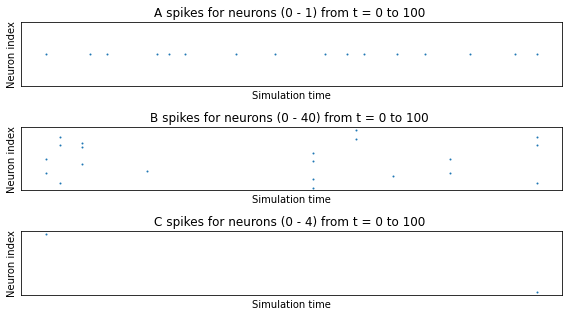

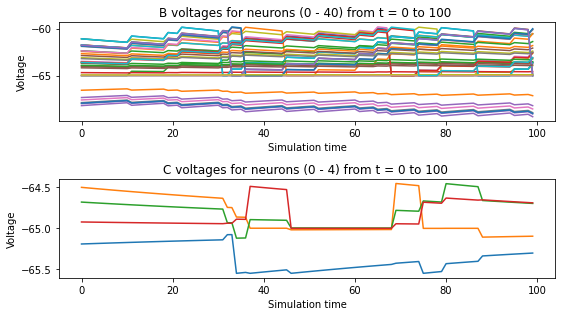

In [26]:
spikes = {
    "A": network.monitors['A'].get('s'), 
    "B": network.monitors['B'].get("s"),
    "C": network.monitors['C'].get("s"),
}
voltages = {"B": network.monitors['B'].get("v"),
            "C": network.monitors['C'].get("v")}

plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()

In [27]:
#convert all the amplitude data into the rate
input_data = torch.zeros(N_samples*time,1)
for i,val in enumerate(z):
    #print(i,val,y[i])
    rate = torch.tensor([val*200]) #convert amplitude to spike rate
    input_data[i*time:(i*time)+time,:] = encoding.poisson(datum=rate.int(),time=time)
    #print(input_data)



In [28]:
#generate input spike activity

dt = torch.linspace(0,time-1,time) #the time axis
ref_spike = torch.exp(-dt/t_mp) ##spike referrence 
input_spike_aux = torch.zeros(1,N_samples)
for i in range(N_samples):
    input_spike_aux[:,i] = aux_spike_activity(input_data[i*time:(i*time)+time,:], ref_spike,tmp = 100,T=100,isPlot = False)

y = torch.nn.functional.one_hot(torch.tensor(s))  #convert label to one hot encoding

In [21]:
#print(input_spike_aux.shape)
#print(input_spike_aux.shape)
#print(y[0:10])
#print(s[0:10])
#print(input_spike_aux[0:10])
#print(y)

In [32]:
#train the network
learning_rate = 0.04
optim = 'GD'
epochs = 100
batch = N_samples


In [30]:
#loop for epochs
eta_w  = learning_rate        #learning rate for synaptic weight
eta_th = 1 * eta_w  #learning rate for voltage threshold
#epochs = 100
L = torch.zeros(epochs) #store in the vector
l = torch.zeros(batch)
plot_train = False
y_pred = torch.zeros(batch,nodes[2])
#initialize the optimization parameters (ADAM, SGD, RMSprop, Momentum)
V,S = initialize_optim_param(network)
t   = 0 #counter required for Adam update
for i in range(epochs): #loop for each epoch         
    for j in tqdm(range(batch)): #loop for each training sample in a batch
        #1. run forward propagation 
        inputs = {"A":input_data[j*time:(j*time)+time,:]}
        network.run(inputs=inputs,time=time)
        #1.1 obtain the spike activity in each nodes of every layer
        #x -> 
        spikes = {       
        "A" : network.monitors["A"].get("s"),
        "B" : network.monitors["B"].get("s"),
        "C" : network.monitors["C"].get("s")
        }

        a_hidden = spikes["B"].squeeze().float() #get the spike activity at the hidden layer
        a_out    = spikes["C"].squeeze().float() #get the spike activity at the output layer           

        #save the spike activity value
        y_pred[j,:] = torch.sum(a_out,dim=0)

        #print(torch.sum(a_out,dim=0)) #print the spike's output activity
        #print(torch.sum(a_hidden,dim=0)) #print the spike's hidden activity

        #x_hidden = inputs["A"].squeeze()#input_data
        x_hidden = input_spike_aux[:,j]
        x_out    = a_hidden

        #2. calculate and keep track the loss
        if (batch==1): #if the only one training sample used
            l[j] = loss_output(y,a_out)       #y[j,:] 

            delta_i_out    =  error_backprop_out(network,y,a_out)#y[j,:]
        else: #multiple training sample in  a batch
            l[j] = loss_output(y[j,:],a_out)       

            delta_i_out    =  error_backprop_out(network,y[j,:],a_out)

        #3.propagate the error backprop        
        delta_i_hid    =  error_backprop(network,a_hidden,a_out,delta_i_out)    

        #4.update the paramaters (weight & threshold)
        #t = t + 1
        #V,S = update_params(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden,ref_spike,t_mp,time,V,S,optim,t)       
        update_params(network,eta_w,eta_th,delta_i_out,delta_i_hid,a_out,a_hidden,x_out,x_hidden,ref_spike,t_mp,time,V,S,optim,t)

        #5.reset the membrane potential in the network
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()      

    L[i] = torch.sum(l) / batch
    #print("vector l",l)
    print(" epochs , loss : ",i,L[i])
    if L[i] < 0.025: #if the loss is less than specified value
            break #stop the loop

100%|██████████| 50/50 [00:04<00:00, 11.75it/s] epochs , loss :  49 tensor(0.6150)



In [31]:
#run the final prediction
y_pred_run = torch.zeros(batch,nodes[2])
for j in range(batch):
    inputs = {"A":input_data[j*time:(j*time)+time,:]}
    network.run(inputs=inputs,time=time)
    a_out    = network.monitors["C"].get("s").squeeze().float()
    y_pred_run[j] = torch.sum(a_out,dim=0)
    #reset state variables 
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()

print("Output spike final prediction (one hot)",y_pred_run)    
#print("target label (one hot)",y)    

print("output vector %s"%(torch.argmax(y_pred_run,dim=1)))
print("target vector %s"%s)
#calculate accuracy
acc = sum(torch.argmax(y_pred_run,dim=1)==torch.from_numpy(s))*100/batch
print("Accuracy %s "%acc.item())

Output spike final prediction (one hot) tensor([[0., 0., 0., 0.],
        [0., 2., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 2., 1., 1.],
        [0., 0., 0., 0.],
        [0., 1., 1., 1.],
        [0., 1., 0., 0.],
        [0., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 2., 1., 1.],
        [0., 0., 0., 0.],
        [0., 2., 1., 1.],
        [0., 2., 1., 1.],
        [0., 2., 1., 1.],
        [0., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 1., 1.],
        [0., 2., 1., 1.],
        [0., 0., 0., 0.],
        [0., 2., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 1., 1.],
        [0., 2., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]

In [54]:
print(torch.argmax(y_pred_run,dim=1))
print(y_pred_run)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])
tensor([[1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 1., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [2., 0., 1., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0.